# Pubmed Banana

## Load packages

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from scipy.optimize import curve_fit
from tqdm import tqdm

In [2]:
%load_ext watermark
%watermark --python --machine
# Python packages versions
%watermark --packages jupyterlab --iversions --watermark
# conda environment name
%watermark --conda

Python implementation: CPython
Python version       : 3.10.10
IPython version      : 8.11.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.15.0-69-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

jupyterlab: 3.6.2

requests  : 2.28.2
pandas    : 1.5.3
matplotlib: 3.7.1
numpy     : 1.24.2

Watermark: 2.3.1

conda environment: pubmed-banana



## Query PubMed

A manual [query](https://pubmed.ncbi.nlm.nih.gov/?term=banana) in PubMed gives results for the term "banana" from [1887](https://pubmed.ncbi.nlm.nih.gov/17832497/) to 2023

Results are very irregular up to around 1960, so we query PubMed from 1960 to last year.

In [3]:
term = "banana"
first_year = 1960
last_year = datetime.now().year
base_url = "https://www.ncbi.nlm.nih.gov/entrez/eutils"

In [4]:
years = np.arange(first_year, last_year)
counts = []
for year in tqdm(years):
    query = f"{term}[Title/Abstract] AND {year}[PDAT]"
    query_url = f"{base_url}/esearch.fcgi?db=pubmed&retmode=json&retmax=9999&term={query}"
    response = requests.get(query_url)
    counts.append(response.json()["esearchresult"]["count"])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:39<00:00,  1.61it/s]


In [5]:
# Convert counts as a Numpy array
counts = np.array(counts).astype(int)

In [6]:
# Normalize first year at 0 to avoir overflow in exponential fitting
years = years - first_year

In [7]:
def func(x, a, b):
    return  a  + np.exp(b * x)

popt, pcov = curve_fit(func, years, counts)

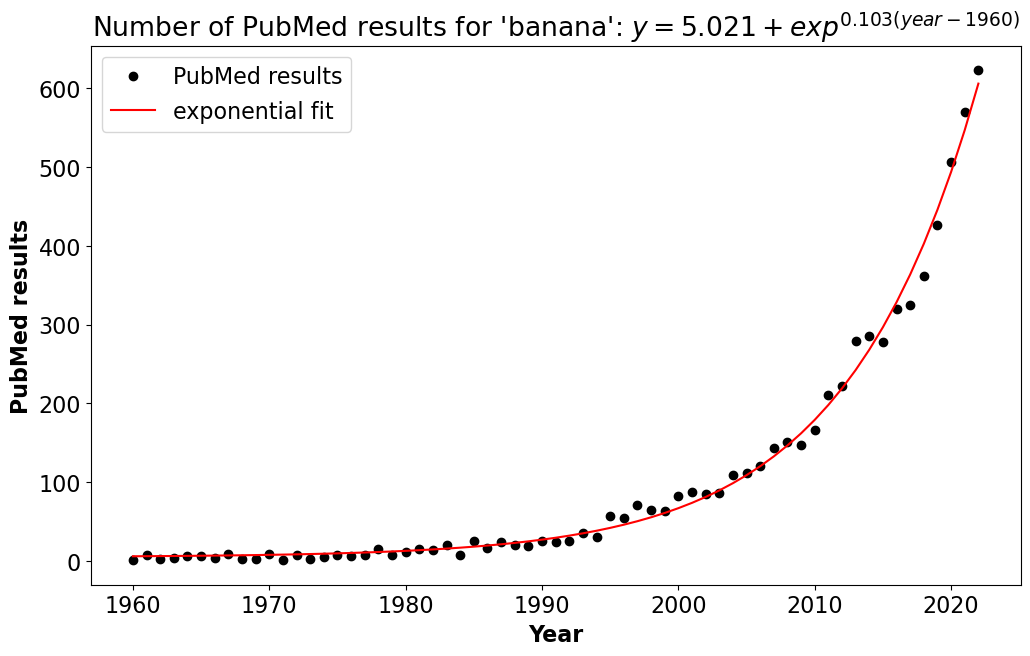

In [8]:
plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(years, counts, 'ko', label="PubMed results")
ax.plot(years, func(years, *popt), 'r-', label="exponential fit")
ax.legend()
ax.set_title(f"Number of PubMed results for '{term}': $y = {popt[0]:.3f} + exp^{{ {popt[1]:.3f}(year-{first_year}) }}$")
ax.set_xlabel("Year", weight="bold")
ax.set_ylabel("PubMed results", weight="bold")
ax.set_xticks(years[::10], (years+first_year)[::10])
plt.show()

In [9]:
residuals = counts - func(years, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((counts-np.mean(counts))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R2: {r_squared:.3f}")

R2: 0.993
